# Content of the notebook

This notebook contains all steps to train and evaluate the fully-connected neural network (FCNN) with extended-connectivity fingerprints as inputs that is presented in the paper "Prediction of Michaelis constants $K_M$ from structural features". The notebook consists of the following steps:

1. Loading train, test, and validation data (that was created with the notebook "Downloading and preprocessing BRENDA data")
2. Training and validating the FCNN
3. Comparing the model to the graph neural network (GNN) and plotting figure 2 of our paper

All datasets are stored in one directory. The location of this directory can be changed (to the corresponding path on your PC) in the python file "directory_infomation.py".

Loading all the necessary packages and functions to execute the code:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from directory_infomation import *
from build_FCNN_and_load_ECFPs import *

#execute on CPU instead of GPU:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

plt.style.use('CCB_plot_style_0v4.mplstyle')
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']        # define a high contrast color scheme

## 1. Loading train, test, and validation data

In [2]:
brenda_train = pd.read_pickle(datasets_dir + "training_data.pkl")
[train_ECFP, train_Y] = create_input_and_output_data_FCNN(df = brenda_train)

brenda_test = pd.read_pickle(datasets_dir + "test_data.pkl")
[test_ECFP, test_Y] = create_input_and_output_data_FCNN(df = brenda_test)

brenda_valid = pd.read_pickle(datasets_dir + "validation_data.pkl")
[valid_ECFP, valid_Y] = create_input_and_output_data_FCNN(df = brenda_valid)

## 2. Training and validating the FCNN

In [3]:
num_epochs = 50
lr = 1e-4
bs = 32 #8
decay =10e-8
momentum=0.8
l2_parameter = 2 #0.15 #0.1 # 0.5 #0.05
all_mae_histories = []

### (a) Training the fully-conncected neural network

Uncomment the following cell for newly training the model:

In [4]:
'''
model = build_model(learning_rate= lr, decay = decay, momentum = momentum, 
                        l2_parameter = l2_parameter) 
history = model.fit(np.array(train_ECFP), np.array(train_Y),
                    validation_data=(np.array(valid_ECFP), np.array(valid_Y)),
                    epochs=num_epochs, batch_size=bs, verbose=1)
mae_history = history.history['val_mse']
all_mae_histories.append(mae_history)

predictions_train = model.predict(train_ECFP)
y_mean = np.mean(train_Y)

plt.plot(mae_history[:], label = "training error", )
valid_mae_history = history.history['mse']
plt.plot(valid_mae_history[:], label = "valid error")
plt.legend()
plt.show()
''';

If the model shall not be trained again, the parameters of the already trained model can be loaded with the following cell. If model was newly trained, do not execute the following cell.

In [5]:
model = build_model(learning_rate= lr, decay = decay, momentum = momentum, 
                        l2_parameter = l2_parameter) 
model.load_weights(datasets_dir + "\model_weights\FCNN_ECFP")

### (b) Validating the model on test and validation set:

In [7]:
pred_test = model.predict(test_ECFP)
FCNN_test_MSE = np.mean(abs(pred_test - np.reshape(test_Y, (-1,1)))**2)
FCNN_test_R2 = r2_score(np.reshape(test_Y, (-1,1)), pred_test)
print("Performance on the test set:")
print("R² value: %s" % FCNN_test_R2)
print("Mean squared error (MSE): %s" % FCNN_test_MSE)

pred_valid = model.predict(valid_ECFP)
FCNN_valid_MSE = np.mean(abs(pred_valid - np.reshape(valid_Y, (-1,1)))**2)
FCNN_valid_R2 = r2_score(np.reshape(valid_Y, (-1,1)), pred_valid)
print("\n Performance on the validation set:")
print("R² value: %s" % FCNN_valid_R2)
print("Mean squared error (MSE): %s" % FCNN_valid_MSE)

Performance on the test set:
R² value: 0.3194275623627739
Mean squared error (MSE): 0.8402650587240215

 Performance on the validation set:
R² value: 0.38730025205693086
Mean squared error (MSE): 0.7447432259963392


## 3. Comparing the FCNN with ECFPs to the GNN and plotting figure 2 of our paper

Loading test and validation errors and scores for the GNN model (the numpy-files are created with the notebook "Training full model with enzyme and substrate information"):

In [8]:
GNN_test_MSE = np.load(datasets_dir + "GNN_test_MSE.npy")
GNN_valid_MSE = np.load(datasets_dir + "GNN_valid_MSE.npy")

GNN_test_R2 = np.load(datasets_dir + "GNN_test_R2.npy")
GNN_valid_R2 = np.load(datasets_dir + "GNN_valid_R2.npy")

#### Figure 2a

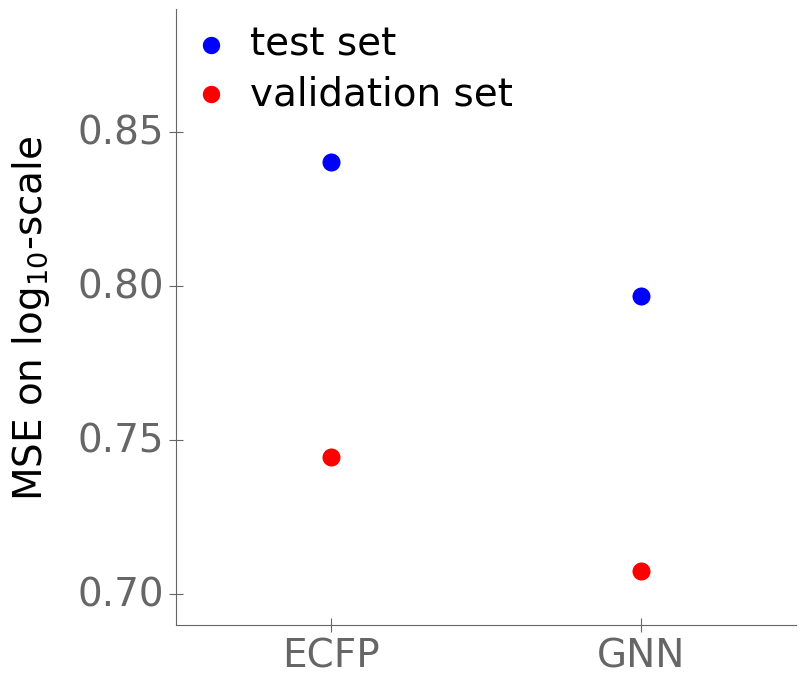

In [12]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})
labs = ["ECFP", "GNN"]
    

plt.scatter(2, GNN_test_MSE , c='blue', marker='o', linewidths= 8, label = "test set")
plt.scatter(1, FCNN_test_MSE, c='blue', marker='o', linewidths= 8)
plt.scatter(2, GNN_valid_MSE, c='red', marker='o', linewidths= 8, label = "validation set")
plt.scatter(1, FCNN_valid_MSE, c='red', marker='o', linewidths= 8)

plt.ylim(0.69, 0.89)
plt.xlim(0.5, 2.5)

ax.set_xticks([1,2])
ax.set_xticklabels(labs)
ax.tick_params(axis='x', length=10)
ax.tick_params(axis='y', length=10)
ax.yaxis.set_label_coords(-0.2, 0.5)


plt.ylabel("MSE on $\log_{10}$-scale")
plt.legend(loc = "upper left")

plt.show()

#### Figure 2b

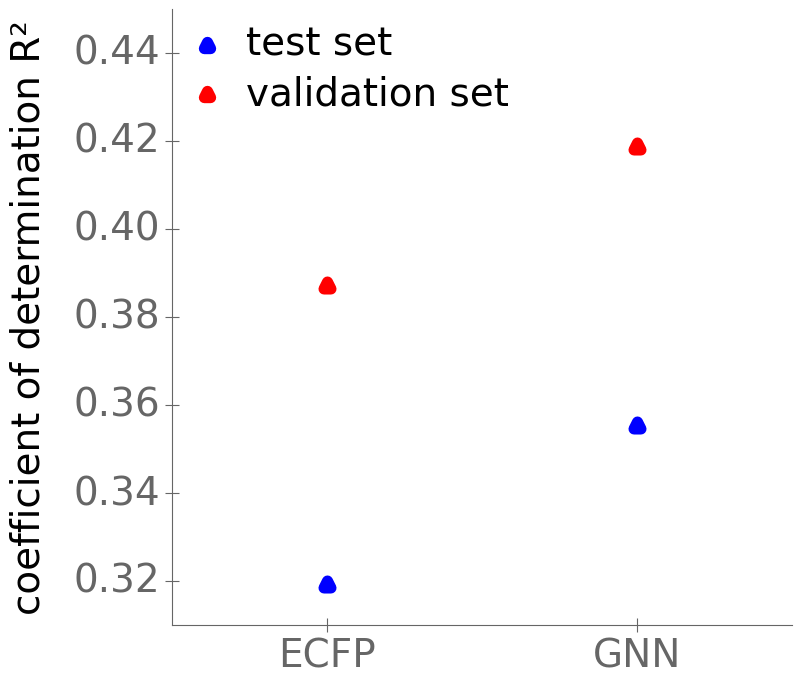

In [10]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})
labs = ["ECFP", "GNN"]

plt.scatter(2, GNN_test_R2 , c='blue',  marker='^', linewidths= 8, label = "test set")
plt.scatter(1, FCNN_test_R2, c='blue',  marker='^', linewidths= 8)
plt.scatter(2, GNN_valid_R2, c='red',  marker='^', linewidths= 8, label = "validation set")
plt.scatter(1, FCNN_valid_R2, c='red',  marker='^', linewidths= 8)

plt.ylim(0.31, 0.45)
plt.xlim(0.5, 2.5)

ax.set_xticks([1,2])
ax.set_xticklabels(labs)
ax.tick_params(axis='x', length=10)
ax.tick_params(axis='y', length=10)
ax.yaxis.set_label_coords(-0.2, 0.5)

plt.ylabel("coefficient of determination R²")
plt.legend(loc = "upper left")
plt.show()